In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image


In [14]:
#hyper params
lr = 1e-6
wd = 1e-3
feature_extract = True
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes =[10,11,14,16,6,7] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'only_relevant_dataset'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 7

In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.Lambda(lambda x: transform_denoise(x)),
                                         transforms.Lambda(lambda x: transform_enhance(x)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy
            inputs = None
            labels = None
            # Iterate over data.
            for (inputs_strong, label_strong), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                if phase == 'train':
                    inputs_strong = inputs_strong.to(device)
                    inputs_weak = inputs_weak.to(device)                
                    labels_weak = labels_weak.to(device)
                else:
                    inputs_val = inputs_strong.to(device)
                    labels_val = label_strong.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # AdaMatch steps
                    if phase == 'train':
                        outputs_weak = model(inputs_weak)
                        _, preds_weak = torch.max(outputs_weak, 1)

                        #loss = criterion(outputs_weak, labels_weak)

                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs_weak, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs_weak = inputs_weak[skip_mask]
                            labels_weak = labels_weak[skip_mask]
                            preds_weak = preds_weak[skip_mask]
                            #loss = criterion(outputs_weak[skip_mask], labels_weak)
                    
                        #skip_mask = skip_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand_as(inputs)  # Expand mask dimensions
                    
                    
                        outputs_strong = model(inputs_strong)
                        pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
                        max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
                        mask = max_probs.ge(0.95).float()

                        unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()
                        loss = lambda_u * unsupervised_loss

                        outputs_strong = pseudo_labels.clone().detach()
                        inputs = torch.cat([inputs_weak, inputs_strong])
                        labels = torch.cat([labels_weak, outputs_strong])

                        supervised_outputs = model(inputs)
                        _, supervised_preds = torch.max(supervised_outputs, 1)
                        supervised_loss = criterion(supervised_outputs, labels)
                        loss += supervised_loss

                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())

                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                        
                        # Calculate balanced accuracy for the validation phase without AdaMatch
                        inputs = inputs_val
                        labels = labels_val
                        supervised_outputs = model(inputs)
                        _, supervised_preds = torch.max(supervised_outputs, 1)
                        
                        loss = criterion(supervised_outputs, labels)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())
                        
                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
                epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]) # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            
            if phase == 'val':
                scheduler.step(epoch_loss)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [7]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array_adamatch(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:

def weighted_score_array(model,models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [10]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = ViT('B_16_imagenet1k', pretrained=True)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [15]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 9628 val strong: 2408 test strong: 2124
train weak: 9628 val weak: 2408 test strong: 2124


In [16]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

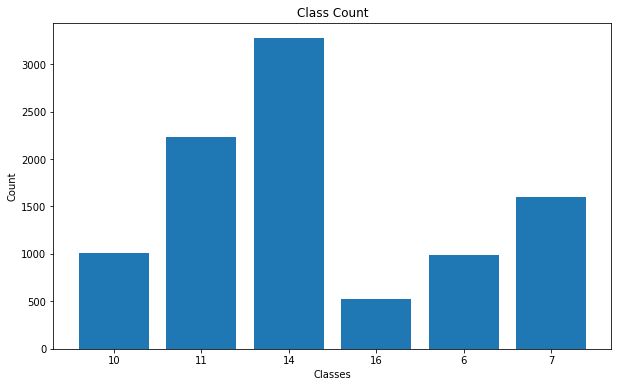

In [17]:
plot_distribution_by_class(trainset_strong, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

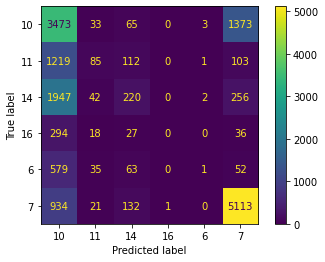

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val Loss: 2.5553 Acc: 0.1541
val Epoch Entropy: 1.5971
val Balanced Accuracy: 0.0000



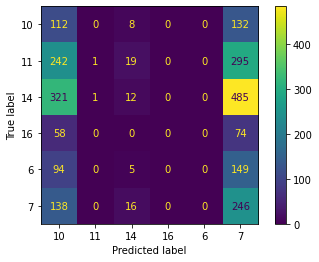

<Figure size 576x432 with 0 Axes>

Number of skipped: 1135

Epoch 1/39
----------
train Loss: 1.1770 Acc: 0.5052
train Epoch Entropy: 1.9468
train Balanced Accuracy: 0.3333



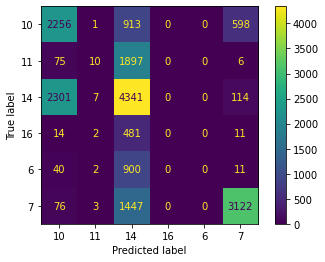

<Figure size 576x432 with 0 Axes>

val Loss: 3.6780 Acc: 0.2164
val Epoch Entropy: 1.4095
val Balanced Accuracy: 0.1333



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


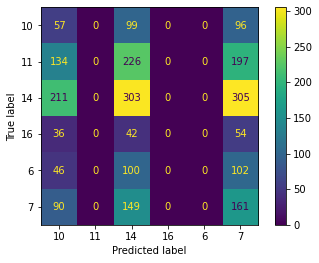

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 2/39
----------
train Loss: 1.1055 Acc: 0.5994
train Epoch Entropy: 1.8969
train Balanced Accuracy: 0.6667



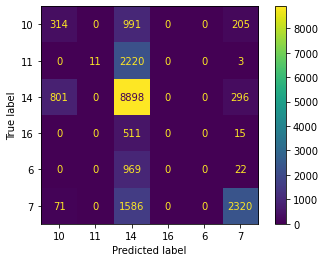

<Figure size 576x432 with 0 Axes>

val Loss: 4.6794 Acc: 0.2878
val Epoch Entropy: 1.1384
val Balanced Accuracy: 0.0000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


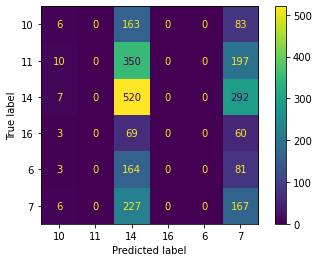

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 3/39
----------
train Loss: 1.0232 Acc: 0.6229
train Epoch Entropy: 1.7505
train Balanced Accuracy: 0.8889



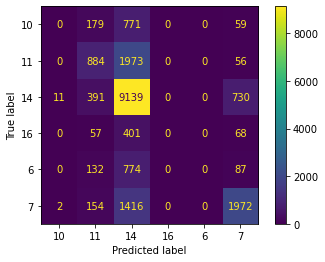

<Figure size 576x432 with 0 Axes>

val Loss: 4.0099 Acc: 0.2978
val Epoch Entropy: 0.9690
val Balanced Accuracy: 0.1667



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


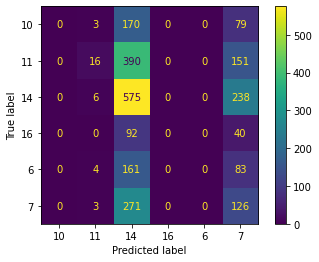

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 4/39
----------
train Loss: 1.0511 Acc: 0.5764
train Epoch Entropy: 1.7216
train Balanced Accuracy: 0.3000



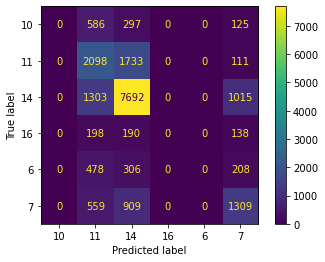

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val Loss: 2.9083 Acc: 0.3235
val Epoch Entropy: 1.0529
val Balanced Accuracy: 0.1250



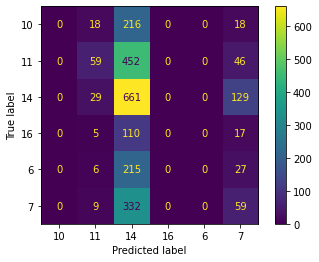

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 5/39
----------
train Loss: 1.0117 Acc: 0.6043
train Epoch Entropy: 1.6946
train Balanced Accuracy: 0.5833



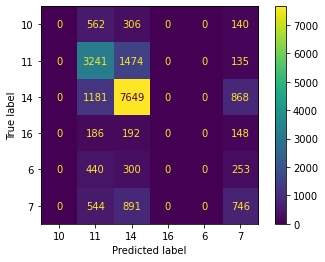

<Figure size 576x432 with 0 Axes>

val Loss: 2.5003 Acc: 0.3704
val Epoch Entropy: 1.1591
val Balanced Accuracy: 0.2500



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


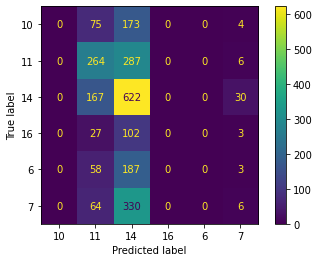

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 6/39
----------
train Loss: 0.9450 Acc: 0.6525
train Epoch Entropy: 1.5948
train Balanced Accuracy: 0.5833



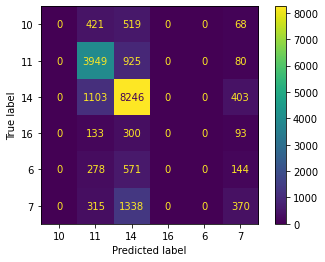

<Figure size 576x432 with 0 Axes>

val Loss: 2.5746 Acc: 0.3783
val Epoch Entropy: 0.9889
val Balanced Accuracy: 0.3889



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


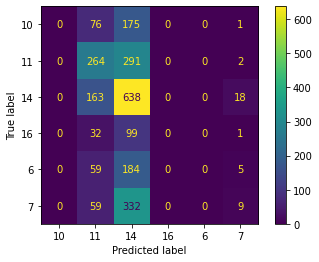

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 7/39
----------
train Loss: 0.8954 Acc: 0.6710
train Epoch Entropy: 1.5092
train Balanced Accuracy: 0.3750



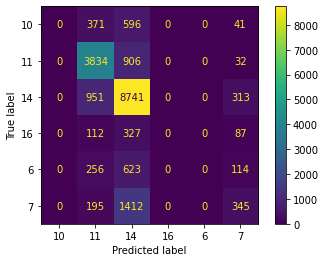

<Figure size 576x432 with 0 Axes>

val Loss: 2.4965 Acc: 0.4049
val Epoch Entropy: 0.9125
val Balanced Accuracy: 0.3000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


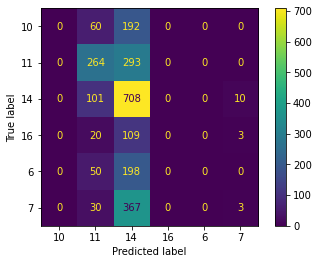

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 8/39
----------
train Loss: 0.8522 Acc: 0.6858
train Epoch Entropy: 1.4352
train Balanced Accuracy: 0.9444



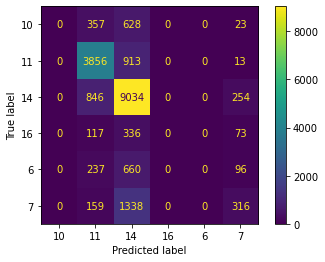

<Figure size 576x432 with 0 Axes>

val Loss: 2.5526 Acc: 0.4132
val Epoch Entropy: 0.7939
val Balanced Accuracy: 0.3333



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


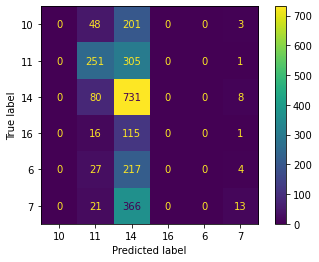

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 9/39
----------
train Loss: 0.8287 Acc: 0.6951
train Epoch Entropy: 1.3807
train Balanced Accuracy: 0.0000



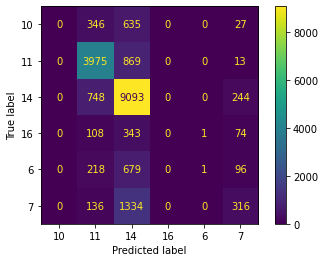

<Figure size 576x432 with 0 Axes>

val Loss: 2.4551 Acc: 0.4190
val Epoch Entropy: 0.8051
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


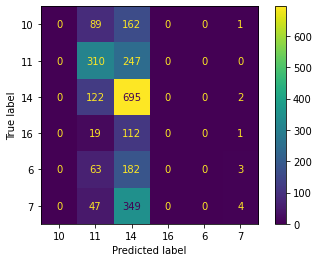

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 10/39
----------
train Loss: 0.8147 Acc: 0.6966
train Epoch Entropy: 1.3412
train Balanced Accuracy: 0.5000



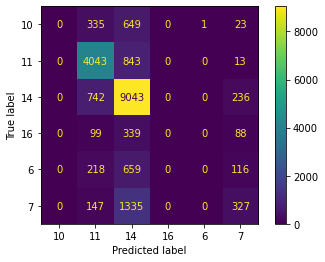

<Figure size 576x432 with 0 Axes>

val Loss: 2.5543 Acc: 0.4261
val Epoch Entropy: 0.7424
val Balanced Accuracy: 0.4000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


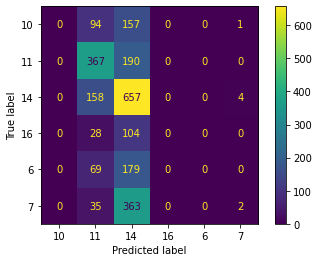

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 11/39
----------
train Loss: 0.8015 Acc: 0.6981
train Epoch Entropy: 1.3108
train Balanced Accuracy: 0.4167



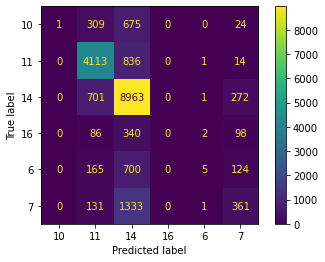

<Figure size 576x432 with 0 Axes>

val Loss: 2.5895 Acc: 0.4390
val Epoch Entropy: 0.6961
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


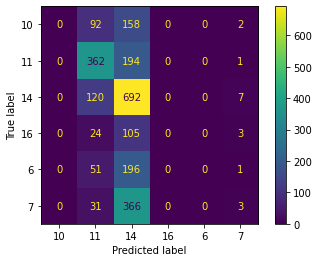

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 12/39
----------
train Loss: 0.7885 Acc: 0.7030
train Epoch Entropy: 1.2935
train Balanced Accuracy: 0.0000



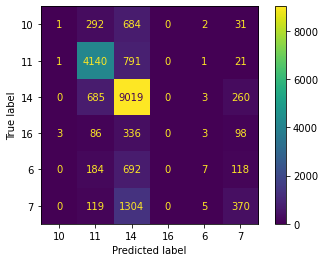

<Figure size 576x432 with 0 Axes>

val Loss: 2.5432 Acc: 0.4514
val Epoch Entropy: 0.7172
val Balanced Accuracy: 0.3750



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


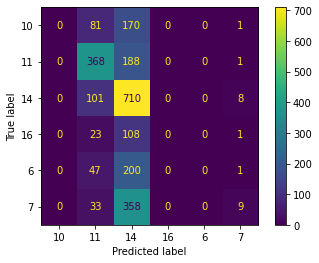

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 13/39
----------
train Loss: 0.7725 Acc: 0.7080
train Epoch Entropy: 1.2673
train Balanced Accuracy: 0.4375



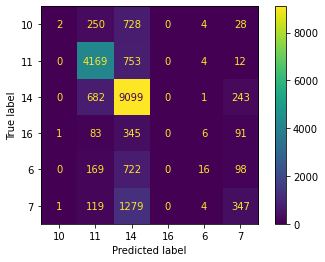

<Figure size 576x432 with 0 Axes>

val Loss: 2.7535 Acc: 0.4460
val Epoch Entropy: 0.6063
val Balanced Accuracy: 0.4000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


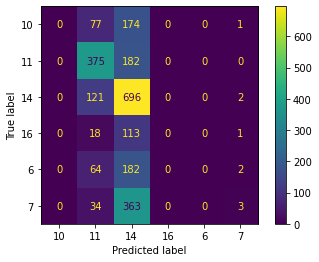

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 14/39
----------
train Loss: 0.7678 Acc: 0.7071
train Epoch Entropy: 1.2513
train Balanced Accuracy: 0.5000



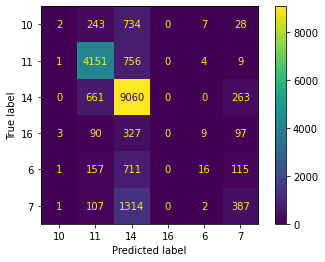

<Figure size 576x432 with 0 Axes>

val Loss: 2.6165 Acc: 0.4431
val Epoch Entropy: 0.6589
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


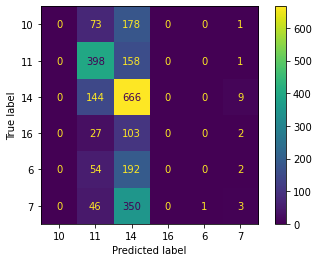

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 15/39
----------
train Loss: 0.7571 Acc: 0.7115
train Epoch Entropy: 1.2368
train Balanced Accuracy: 0.5556



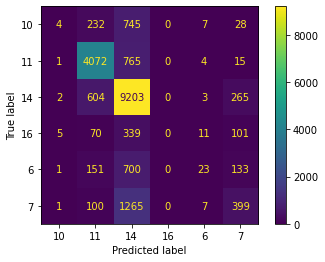

<Figure size 576x432 with 0 Axes>

val Loss: 2.7400 Acc: 0.4448
val Epoch Entropy: 0.6174
val Balanced Accuracy: 0.4000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


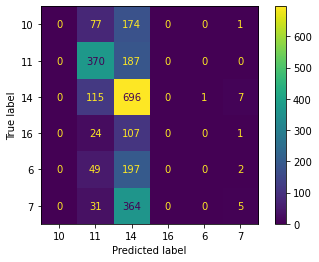

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 16/39
----------
train Loss: 0.7424 Acc: 0.7202
train Epoch Entropy: 1.2138
train Balanced Accuracy: 0.6000



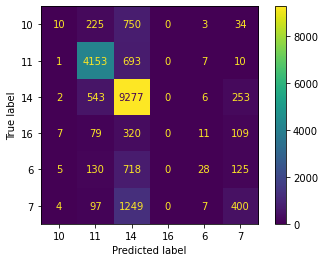

<Figure size 576x432 with 0 Axes>

val Loss: 2.7134 Acc: 0.4460
val Epoch Entropy: 0.5999
val Balanced Accuracy: 0.3333



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


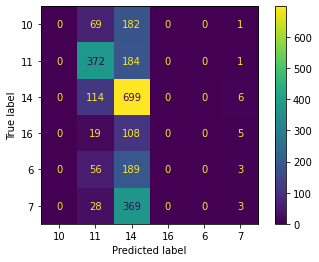

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 17/39
----------
train Loss: 0.7381 Acc: 0.7184
train Epoch Entropy: 1.1987
train Balanced Accuracy: 0.5833



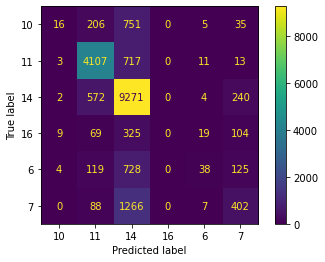

<Figure size 576x432 with 0 Axes>

val Loss: 2.7017 Acc: 0.4614
val Epoch Entropy: 0.6133
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


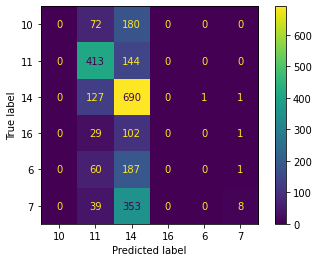

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 18/39
----------
train Loss: 0.7308 Acc: 0.7197
train Epoch Entropy: 1.1911
train Balanced Accuracy: 0.0000



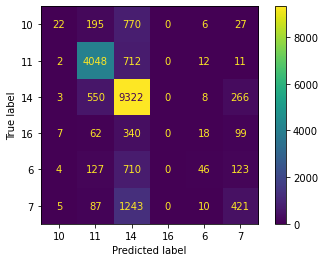

<Figure size 576x432 with 0 Axes>

val Loss: 2.8381 Acc: 0.4452
val Epoch Entropy: 0.5477
val Balanced Accuracy: 0.4375



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


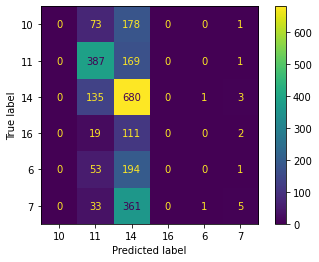

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 19/39
----------
train Loss: 0.7227 Acc: 0.7250
train Epoch Entropy: 1.1739
train Balanced Accuracy: 0.0000



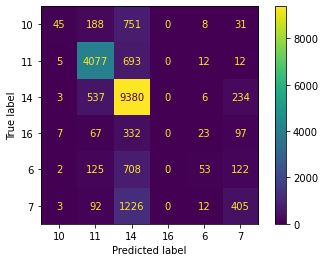

<Figure size 576x432 with 0 Axes>

val Loss: 2.7870 Acc: 0.4593
val Epoch Entropy: 0.5561
val Balanced Accuracy: 0.4000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


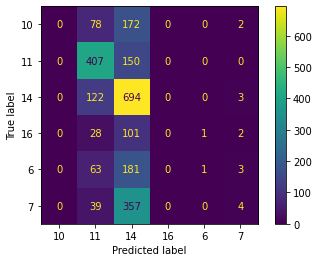

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 20/39
----------
train Loss: 0.7160 Acc: 0.7266
train Epoch Entropy: 1.1604
train Balanced Accuracy: 0.0000



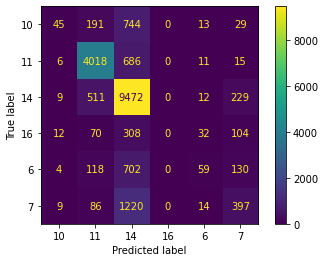

<Figure size 576x432 with 0 Axes>

val Loss: 2.7371 Acc: 0.4522
val Epoch Entropy: 0.5802
val Balanced Accuracy: 0.3750



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


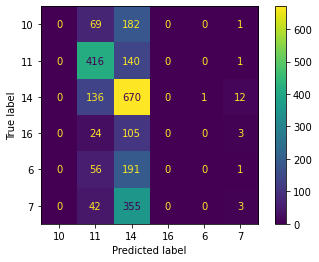

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 21/39
----------
train Loss: 0.7081 Acc: 0.7266
train Epoch Entropy: 1.1459
train Balanced Accuracy: 0.6667



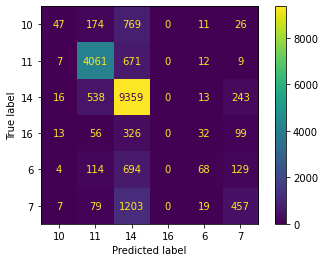

<Figure size 576x432 with 0 Axes>

val Loss: 2.9006 Acc: 0.4502
val Epoch Entropy: 0.5198
val Balanced Accuracy: 0.4167



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


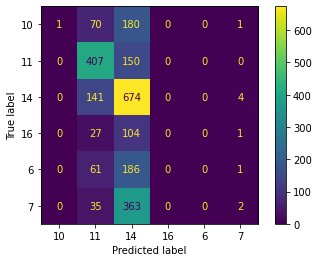

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 22/39
----------
train Loss: 0.7029 Acc: 0.7324
train Epoch Entropy: 1.1407
train Balanced Accuracy: 0.5833



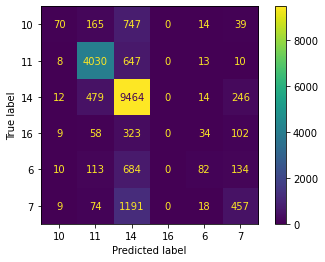

<Figure size 576x432 with 0 Axes>

val Loss: 2.9186 Acc: 0.4556
val Epoch Entropy: 0.4983
val Balanced Accuracy: 0.4000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


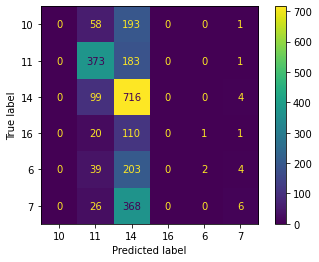

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 23/39
----------
train Loss: 0.6972 Acc: 0.7324
train Epoch Entropy: 1.1324
train Balanced Accuracy: 0.6875



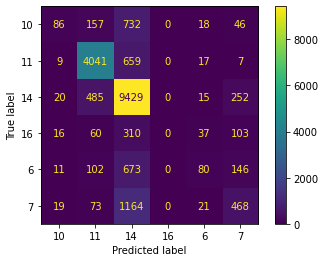

<Figure size 576x432 with 0 Axes>

val Loss: 2.8989 Acc: 0.4556
val Epoch Entropy: 0.5100
val Balanced Accuracy: 0.2500



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


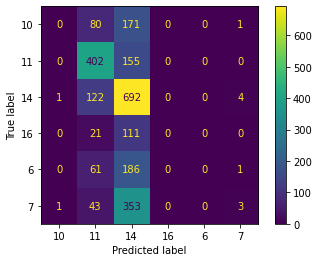

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 24/39
----------
train Loss: 0.6965 Acc: 0.7309
train Epoch Entropy: 1.1249
train Balanced Accuracy: 0.0000



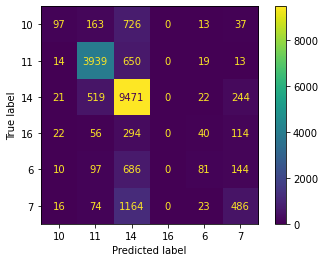

<Figure size 576x432 with 0 Axes>

val Loss: 2.8282 Acc: 0.4647
val Epoch Entropy: 0.5372
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


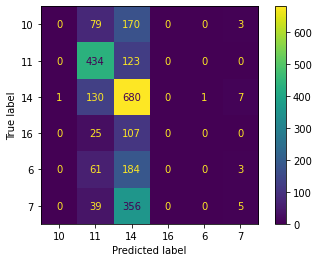

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 25/39
----------
train Loss: 0.6868 Acc: 0.7362
train Epoch Entropy: 1.1129
train Balanced Accuracy: 0.5000



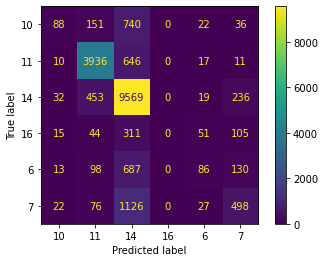

<Figure size 576x432 with 0 Axes>

val Loss: 3.1057 Acc: 0.4610
val Epoch Entropy: 0.4542
val Balanced Accuracy: 0.3750



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


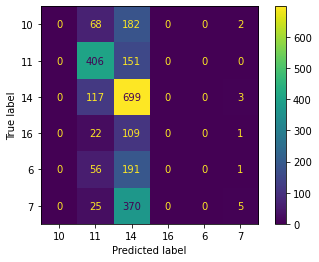

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 26/39
----------
train Loss: 0.6817 Acc: 0.7402
train Epoch Entropy: 1.1038
train Balanced Accuracy: 0.7500



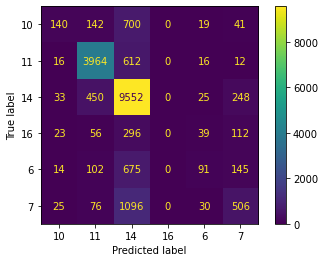

<Figure size 576x432 with 0 Axes>

val Loss: 2.8456 Acc: 0.4560
val Epoch Entropy: 0.5194
val Balanced Accuracy: 0.2500



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


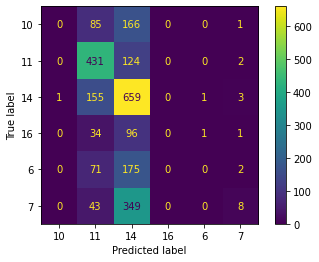

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 27/39
----------
train Loss: 0.6773 Acc: 0.7420
train Epoch Entropy: 1.0955
train Balanced Accuracy: 0.0000



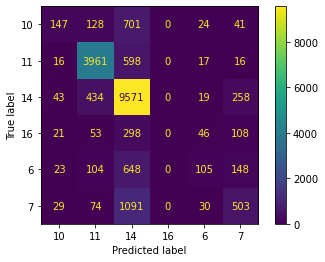

<Figure size 576x432 with 0 Axes>

val Loss: 3.1944 Acc: 0.4585
val Epoch Entropy: 0.4131
val Balanced Accuracy: 0.0000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


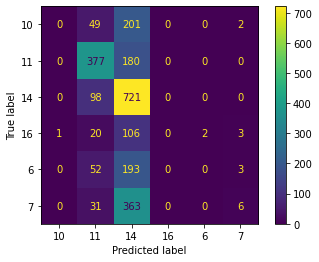

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 28/39
----------
train Loss: 0.6761 Acc: 0.7410
train Epoch Entropy: 1.0900
train Balanced Accuracy: 0.5000



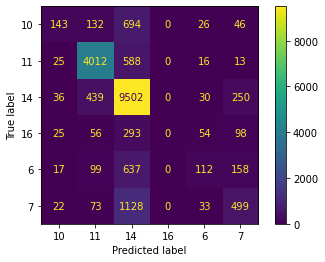

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val Loss: 3.0834 Acc: 0.4481
val Epoch Entropy: 0.4679
val Balanced Accuracy: 0.4500



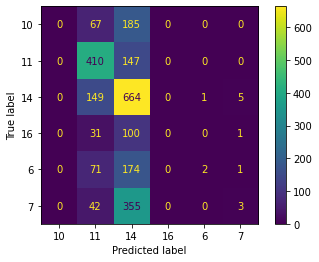

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 29/39
----------
train Loss: 0.6638 Acc: 0.7475
train Epoch Entropy: 1.0808
train Balanced Accuracy: 0.4500



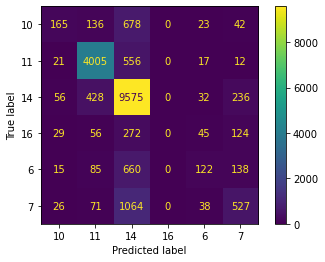

<Figure size 576x432 with 0 Axes>

val Loss: 3.0467 Acc: 0.4572
val Epoch Entropy: 0.4671
val Balanced Accuracy: 0.3750



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


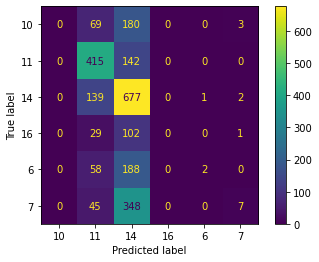

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 30/39
----------
train Loss: 0.6629 Acc: 0.7482
train Epoch Entropy: 1.0768
train Balanced Accuracy: 0.4000



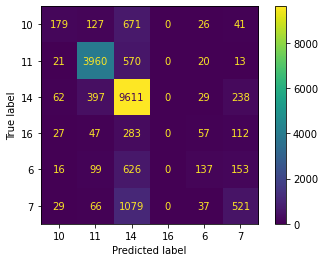

<Figure size 576x432 with 0 Axes>

val Loss: 3.5099 Acc: 0.4576
val Epoch Entropy: 0.3601
val Balanced Accuracy: 0.6667



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


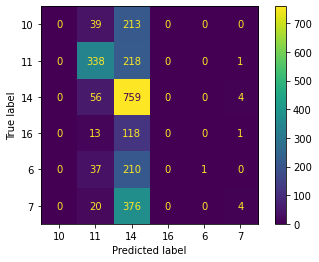

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 31/39
----------
train Loss: 0.6534 Acc: 0.7533
train Epoch Entropy: 1.0677
train Balanced Accuracy: 0.0000



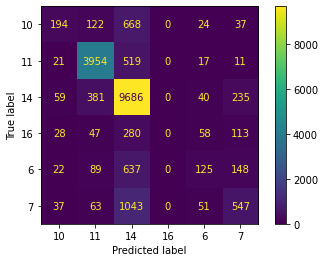

<Figure size 576x432 with 0 Axes>

val Loss: 3.2495 Acc: 0.4610
val Epoch Entropy: 0.4211
val Balanced Accuracy: 0.5000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


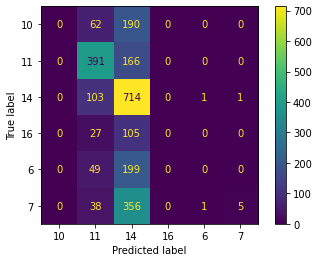

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 32/39
----------
train Loss: 0.6524 Acc: 0.7516
train Epoch Entropy: 1.0611
train Balanced Accuracy: 0.0000



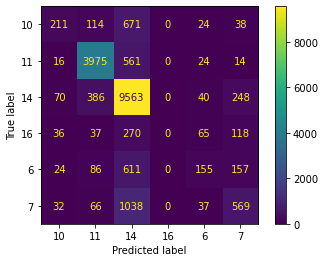

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val Loss: 3.1558 Acc: 0.4543
val Epoch Entropy: 0.4315
val Balanced Accuracy: 0.1667



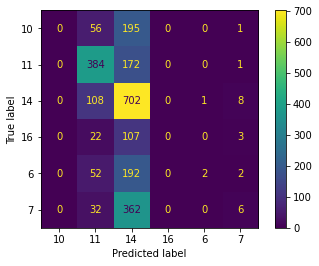

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 33/39
----------
train Loss: 0.6432 Acc: 0.7546
train Epoch Entropy: 1.0511
train Balanced Accuracy: 0.5000



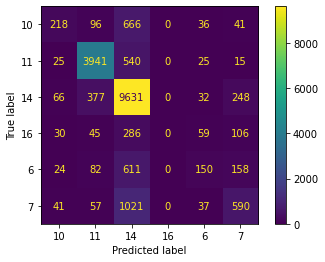

<Figure size 576x432 with 0 Axes>

val Loss: 3.0730 Acc: 0.4581
val Epoch Entropy: 0.4519
val Balanced Accuracy: 0.3125



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


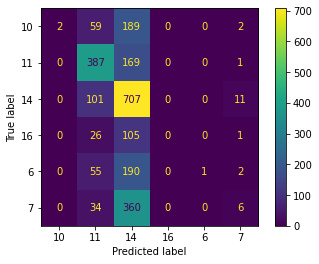

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 34/39
----------
train Loss: 0.6458 Acc: 0.7545
train Epoch Entropy: 1.0446
train Balanced Accuracy: 0.0000



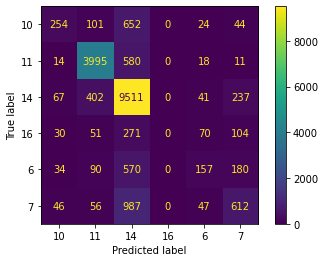

<Figure size 576x432 with 0 Axes>

val Loss: 3.0747 Acc: 0.4493
val Epoch Entropy: 0.4574
val Balanced Accuracy: 0.5833



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


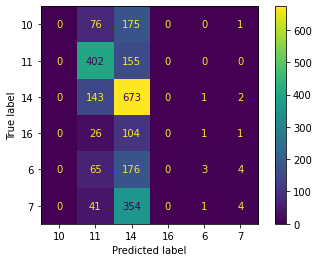

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 35/39
----------
train Loss: 0.6439 Acc: 0.7570
train Epoch Entropy: 1.0433
train Balanced Accuracy: 0.5556



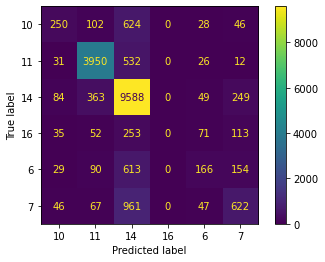

<Figure size 576x432 with 0 Axes>

val Loss: 3.2817 Acc: 0.4556
val Epoch Entropy: 0.4013
val Balanced Accuracy: 0.4167



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


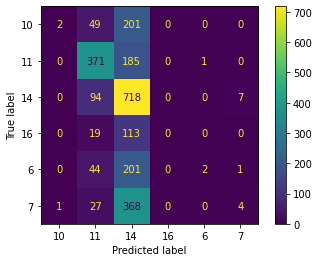

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 36/39
----------
train Loss: 0.6371 Acc: 0.7596
train Epoch Entropy: 1.0374
train Balanced Accuracy: 1.0000



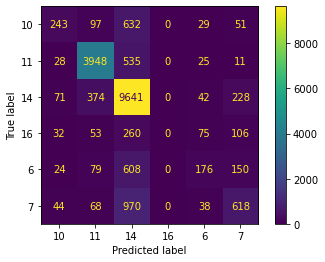

<Figure size 576x432 with 0 Axes>

val Loss: 3.2083 Acc: 0.4585
val Epoch Entropy: 0.4026
val Balanced Accuracy: 0.3750



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


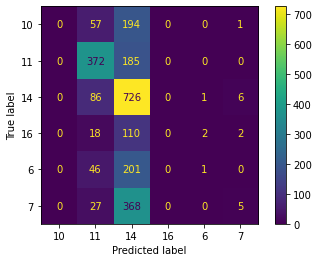

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 37/39
----------
train Loss: 0.6349 Acc: 0.7592
train Epoch Entropy: 1.0349
train Balanced Accuracy: 0.6667



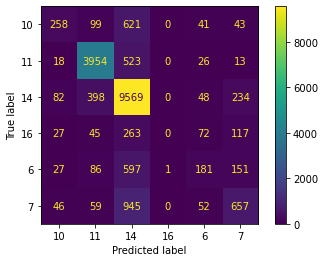

<Figure size 576x432 with 0 Axes>

val Loss: 3.4028 Acc: 0.4551
val Epoch Entropy: 0.3705
val Balanced Accuracy: 0.4167



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


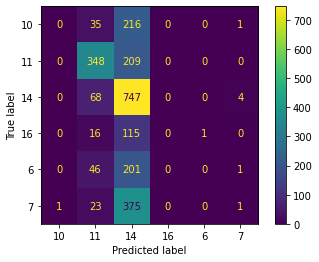

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 38/39
----------
train Loss: 0.6274 Acc: 0.7645
train Epoch Entropy: 1.0251
train Balanced Accuracy: 0.9444



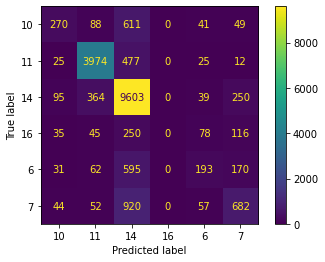

<Figure size 576x432 with 0 Axes>

val Loss: 3.2685 Acc: 0.4518
val Epoch Entropy: 0.3966
val Balanced Accuracy: 0.0000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


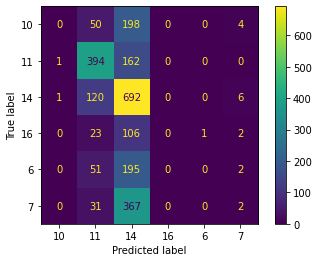

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Epoch 39/39
----------
train Loss: 0.6231 Acc: 0.7664
train Epoch Entropy: 1.0179
train Balanced Accuracy: 0.8889



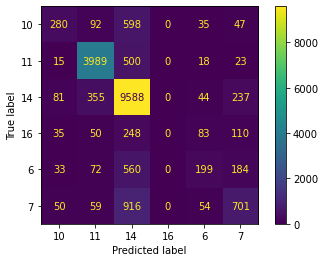

<Figure size 576x432 with 0 Axes>

val Loss: 3.2657 Acc: 0.4635
val Epoch Entropy: 0.4099
val Balanced Accuracy: 0.3000



/home/rishav/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


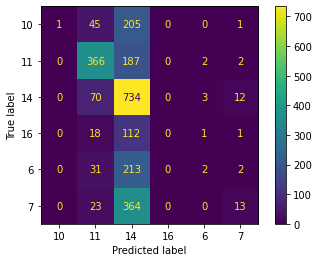

<Figure size 576x432 with 0 Axes>

Number of skipped: 1204

Training complete in 192m 17s
Best val Acc: 0.464701


In [14]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adamax(params_to_update, lr=lr)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=2)
    #exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)



    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.4459, device='cuda:0')
The Test Balanced Accuracy: 0.2591241022409204


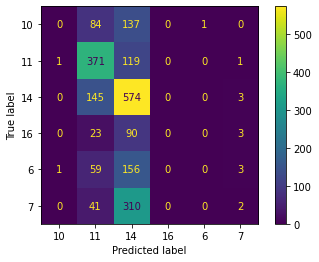

<Figure size 576x432 with 0 Axes>

In [15]:
test_model(model, testset_strong)


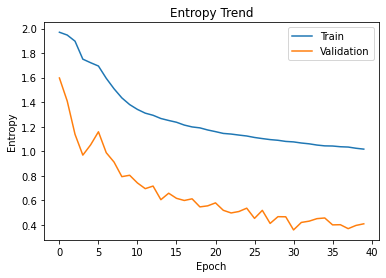

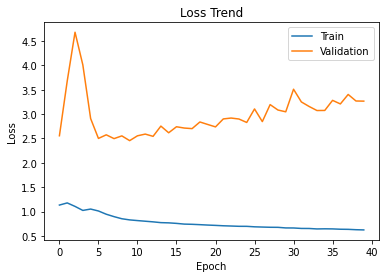

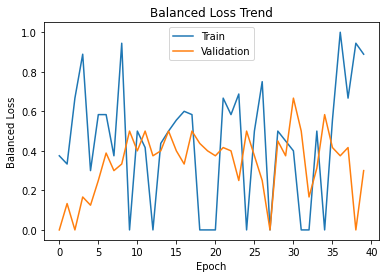

In [16]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [20]:
train_X, train_Y = weighted_score_array_adamatch(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model, model_list, testset_strong)


In [21]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

#Balanced Accuracy
balanced_acc = balanced_accuracy_score(test_Y, predictions)  # Calculate balanced accuracy


print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

print("Dummy Classifier Balanced Accuracy/ Random Baseline:", balanced_acc)



Dummy Classifier Accuracy/ Random Baseline: 0.1638418079096045
Dummy Classifier Balanced Accuracy/ Random Baseline: 0.15711181948335343


Accuracy for SVM: 0.4467984934086629
Balanced Accuracy:0.2591796072571384


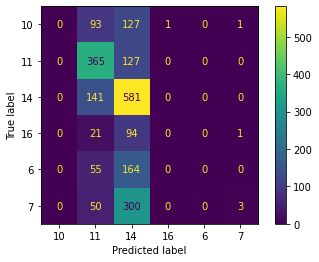

<Figure size 576x432 with 0 Axes>

In [22]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.4467984934086629
Balanced Accuracy:0.2599153440073336


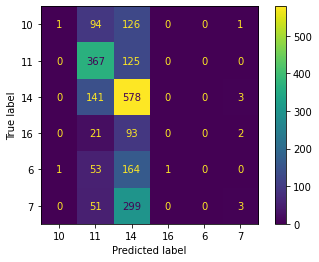

<Figure size 576x432 with 0 Axes>

In [23]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()